In [1]:
from fama_data.FamaData import FamaData
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings('ignore')

In [2]:
fd = FamaData('data/', end_date = '2022-09-30')

In [3]:
share_issue_delta = fd.get_net_share_issue_data()['Hi 10'] - fd.get_net_share_issue_data()['Lo 10']

shortterm_rev_delta = fd.get_shortterm_reversal_data()['Hi PRIOR'] - fd.get_shortterm_reversal_data()['Lo PRIOR']
longterm_rev_delta = fd.get_longterm_reversal_data()['Hi PRIOR'] - fd.get_longterm_reversal_data()['Lo PRIOR']

innov_delta = fd.get_10_industry_data()['HiTec'] - fd.get_10_industry_data()['NoDur'] 
growth_delta = .5*fd.get_10_industry_data()['HiTec'] + .5*fd.get_10_industry_data()['Hlth '] \
             - .5*fd.get_10_industry_data()['Utils'] - .5*fd.get_10_industry_data()['Manuf']
durable_delta = fd.get_10_industry_data()['Durbl'] - fd.get_10_industry_data()['Manuf']

service_minus_goods = 2 * fd.get_49_industry_data()['PerSv'] + 2 * fd.get_49_industry_data()['BusSv'] \
                    + fd.get_49_industry_data()['Softw'] + fd.get_49_industry_data()['Insur'] \
                    + fd.get_49_industry_data()['Fins'] + fd.get_49_industry_data()['Banks'] \
                    - fd.get_49_industry_data()['Hshld'] - fd.get_49_industry_data()['BldMt'] \
                    - fd.get_49_industry_data()['ElcEq'] - fd.get_49_industry_data()['Aero'] \
                    - fd.get_49_industry_data()['Food '] - fd.get_49_industry_data()['Oil'] \
                    - 2 * fd.get_49_industry_data()['Whlsl']

needs_minus_wants = fd.get_49_industry_data()['Food '] + fd.get_49_industry_data()['Util'] \
                    + fd.get_49_industry_data()['Hlth '] + fd.get_49_industry_data()['MedEq'] \
                    + fd.get_49_industry_data()['Drugs'] + fd.get_49_industry_data()['Insur'] \
                    - fd.get_49_industry_data()['Guns'] - fd.get_49_industry_data()['Softw'] \
                    - fd.get_49_industry_data()['Autos'] - fd.get_49_industry_data()['Whlsl'] \
                    - 2*fd.get_49_industry_data()['Hshld']


accrual_delta = fd.get_accrual_data()['Hi 10'] - fd.get_accrual_data()['Lo 10']
cashflow_price_delta = fd.get_cashflow_price_data()['Hi 10'] - fd.get_cashflow_price_data()['Lo 10']
market_beta_delta = fd.get_market_beta_data()['Hi 10'] - fd.get_market_beta_data()['Lo 10']
dividend_yield_delta = fd.get_dividend_yield_data()['Hi 10'] - fd.get_dividend_yield_data()['Lo 10']
earnings_price_delta = fd.get_earnings_price_data()['Hi 10'] - fd.get_earnings_price_data()['Lo 10']
variance_delta = fd.get_variance_data()['Hi 10'] - fd.get_variance_data()['Lo 10']


share_issue_delta.name = 'share_issue_delta'
shortterm_rev_delta.name = 'shortterm_rev_delta'
longterm_rev_delta.name = 'longterm_rev_delta'
innov_delta.name = 'innov_delta'
growth_delta.name = 'growth_delta'
durable_delta.name = 'durable_delta'
service_minus_goods.name = 'service_minus_goods'
needs_minus_wants.name = 'needs_minus_wants'
accrual_delta.name = 'accrual_delta'
cashflow_price_delta.name = 'cashflow_price_delta'
market_beta_delta.name = 'market_beta_delta'
dividend_yield_delta.name = 'dividend_yield_delta'
earnings_price_delta.name = 'earnings_price_delta'
variance_delta.name = 'variance_delta'

In [4]:
# Classic Fama-French 3-factor model components
excess_returns = fd.get_excess_return_data()['exmt']
SMB_proxy = fd.get_size_data()['Hi 10'] - fd.get_size_data()['Lo 10']
HML_proxy = fd.get_book_to_market_data()['Hi 10'] - fd.get_book_to_market_data()['Lo 10']

# Fama-French 5-factor model components
RMW_proxy = fd.get_operating_profitability_data()['Hi 10'] - fd.get_operating_profitability_data()['Lo 10']
CMA_proxy = fd.get_investment_data()['Hi 10'] - fd.get_investment_data()['Lo 10']

# And momentum
MOM_proxy = fd.get_momentum_data()['Hi PRIOR'] - fd.get_momentum_data()['Lo PRIOR']

SMB_proxy.name = 'SMB'
HML_proxy.name = 'HML'
RMW_proxy.name = 'RMW'
CMA_proxy.name = 'CMA'
MOM_proxy.name = 'MOM'

In [5]:
# Critical for concat to work properly
for x in [excess_returns, share_issue_delta, shortterm_rev_delta, longterm_rev_delta, 
                innov_delta, growth_delta, durable_delta, service_minus_goods, needs_minus_wants, 
                accrual_delta, cashflow_price_delta, market_beta_delta, dividend_yield_delta, 
                earnings_price_delta, variance_delta,]: #port, SMB_proxy, HML_proxy, RMW_proxy, CMA_proxy]:
    x.reset_index(drop=True, inplace=True)

In [6]:
df = pd.concat([excess_returns, share_issue_delta, shortterm_rev_delta, longterm_rev_delta, 
                innov_delta, growth_delta, durable_delta, service_minus_goods, needs_minus_wants, 
                accrual_delta, cashflow_price_delta, market_beta_delta, dividend_yield_delta, 
                earnings_price_delta, variance_delta,], axis = 1) #port, SMB_proxy, HML_proxy, RMW_proxy, CMA_proxy], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   exmt                  711 non-null    float64
 1   share_issue_delta     711 non-null    float64
 2   shortterm_rev_delta   711 non-null    float64
 3   longterm_rev_delta    711 non-null    float64
 4   innov_delta           711 non-null    float64
 5   growth_delta          711 non-null    float64
 6   durable_delta         711 non-null    float64
 7   service_minus_goods   711 non-null    float64
 8   needs_minus_wants     711 non-null    float64
 9   accrual_delta         711 non-null    float64
 10  cashflow_price_delta  711 non-null    float64
 11  market_beta_delta     711 non-null    float64
 12  dividend_yield_delta  711 non-null    float64
 13  earnings_price_delta  711 non-null    float64
 14  variance_delta        711 non-null    float64
dtypes: float64(15)
memory u

In [7]:
df

,exmt,share_issue_delta,shortterm_rev_delta,longterm_rev_delta,innov_delta,growth_delta,durable_delta,service_minus_goods,needs_minus_wants,accrual_delta,cashflow_price_delta,market_beta_delta,dividend_yield_delta,earnings_price_delta,variance_delta
0,-0.0039,2.09,-0.16,-1.34,-0.20,0.235,1.18,-111.46,3.93,-2.52,1.30,-2.13,0.15,-0.26,-1.98
1,0.0507,1.55,-0.64,0.52,0.25,2.145,0.34,-119.26,2.11,0.04,0.49,6.95,-1.70,0.24,2.20
2,-0.0157,-1.86,-0.89,2.00,1.82,-0.330,0.53,-97.15,-2.90,1.65,-1.94,-0.58,0.34,-1.93,-1.91
3,0.0253,-0.12,-1.59,1.44,5.64,4.895,7.17,-102.87,-7.74,-13.73,-0.96,1.77,-6.77,-3.48,-0.56
4,-0.0085,-1.20,-5.51,1.65,0.84,-0.615,-5.15,-112.37,-0.82,5.02,-0.10,1.43,-0.35,0.76,-5.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,-0.0034,-3.47,1.40,-12.12,-0.47,-2.715,-8.32,-14.85,22.29,1.58,3.92,-2.69,7.46,7.99,-7.68
707,-0.0843,2.62,-7.20,5.87,-4.44,2.785,-2.56,-6.29,3.25,-1.08,-2.57,-15.32,4.10,-0.46,-6.57
708,0.0957,4.61,-11.95,10.44,7.40,-0.135,19.10,2.95,-12.68,2.80,-9.54,23.83,-12.40,-8.17,13.04
709,-0.0377,4.10,0.08,-6.67,-3.29,-3.430,-2.29,-16.73,-0.57,-1.06,4.78,-1.96,6.00,4.23,4.96


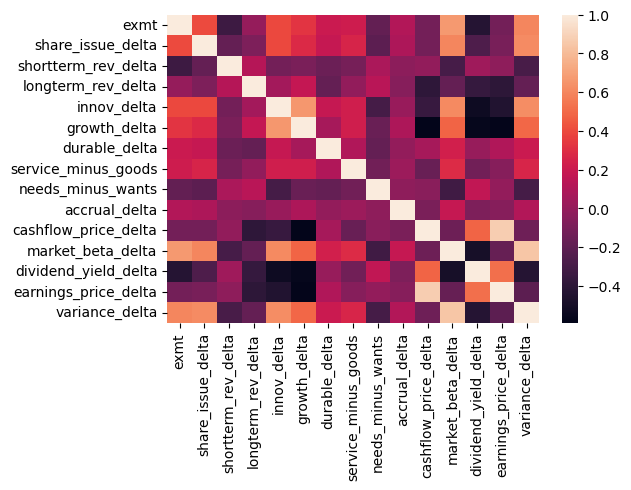

In [8]:
plt.rcParams["figure.figsize"] = (6, 4)
sns.heatmap(df.corr(), annot = False)
plt.show()

Here we see some evidence of high multi-collinearity. Let's check the VIF.

In [9]:
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns

vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                          for i in range(len(df.columns))]
vif_data

,feature,VIF
0,exmt,2.021778
1,share_issue_delta,1.759242
2,shortterm_rev_delta,1.189419
3,longterm_rev_delta,1.620850
4,innov_delta,2.656681
5,growth_delta,2.579253
6,durable_delta,1.149353
7,service_minus_goods,1.201325
8,needs_minus_wants,1.182680
9,accrual_delta,1.077429


In [10]:
# Surprisingly, the VIFs are all below 10. Let's add the spread portfolio and see what happens

In [11]:
url = 'http://diether.org/prephd/10-port_mom_ew.csv'
port = pd.read_csv(url,parse_dates=['caldt'])
port = port.query('caldt >= "1963-07-31" and caldt <= "2023-02-28"')
port.set_index('caldt', inplace=True)
y = port['p4'] - port['p0']
y.describe()

count    711.000000
mean       1.403296
std        5.244275
min      -39.139129
25%       -0.695511
50%        1.639717
75%        3.852537
max       25.892441
dtype: float64

In [12]:
df['ret'] = y.reset_index(drop=True)
df.head(3)

,exmt,share_issue_delta,shortterm_rev_delta,longterm_rev_delta,innov_delta,growth_delta,durable_delta,service_minus_goods,needs_minus_wants,accrual_delta,cashflow_price_delta,market_beta_delta,dividend_yield_delta,earnings_price_delta,variance_delta,ret
0,-0.0039,2.09,-0.16,-1.34,-0.20,0.235,1.18,-111.46,3.93,-2.52,1.30,-2.13,0.15,-0.26,-1.98,1.257761
1,0.0507,1.55,-0.64,0.52,0.25,2.145,0.34,-119.26,2.11,0.04,0.49,6.95,-1.70,0.24,2.20,3.739185
2,-0.0157,-1.86,-0.89,2.00,1.82,-0.330,0.53,-97.15,-2.90,1.65,-1.94,-0.58,0.34,-1.93,-1.91,0.929515


In [13]:
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns

vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                          for i in range(len(df.columns))]
vif_data

,feature,VIF
0,exmt,2.022977
1,share_issue_delta,1.760267
2,shortterm_rev_delta,1.234210
3,longterm_rev_delta,1.635078
4,innov_delta,2.658870
5,growth_delta,2.589170
6,durable_delta,1.195178
7,service_minus_goods,1.201614
8,needs_minus_wants,1.189756
9,accrual_delta,1.111386


All good! Let's export this dataset.

In [14]:
df.drop('ret', axis=1, inplace=True)
df['caldt'] = port.index
df.to_csv('exported/alt_ff_factors.csv', index=False)